# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 2 модели похожую по архитектуре на модель из ULMFit для задачи классификации текста (датасет - lenta_40k )
В моделях должно быть как минимум два рекуррентных слоя, а финальный вектор для классификации составляться из последнего состояния RNN (так делалось в семинаре), а также AveragePooling и MaxPooling из всех векторов последовательности (конкатенируйте последнее состояния и результаты пулинга). В первой модели используйте обычные слои, а во второй Bidirectional. Рассчитайте по классовую точность/полноту/f-меру для каждой из модели (результаты не должны быть совсем близкие к нулю после обучения на хотя бы нескольких эпохах). 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv('lenta_40k.csv')

In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [6]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [7]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [8]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [9]:

MAX_LEN = 200

In [10]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [11]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [12]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [14]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

layer1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
layer2 = keras.layers.LSTM(128, return_sequences=True)(layer1)
layer3 = keras.layers.LSTM(128, return_sequences=True)(layer2)

#если почитать документацию, то они используют dropout, попробую применить его после этих трех слоев
dropout = keras.layers.Dropout(rate = 0.4)(layer3)

pool1 = keras.layers.GlobalMaxPooling1D()(dropout)
pool2 = keras.layers.GlobalAveragePooling1D()(dropout)

concat = keras.layers.concatenate((layer3[:, -1, :], pool1, pool2,))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 30)   │    722,790 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 200, 128)  │     81,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 200, 128)  │    131,584 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 200, 128)  │    131,584 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 128)  │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ dropout[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 19)        │      7,315 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,074,681 (4.10 MB)

 Trainable params: 1,074,681 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

In [17]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5,
         callbacks = [checkpoint, early_stop])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 2.7065 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 170s 8s/step - loss: 2.6986 - rec@prec: 0.0000e+00 - val_loss: 2.3366 - val_rec@prec: 0.0000e+00
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 2.3081 - rec@prec: 0.0000e+00
Epoch 2: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - loss: 2.3058 - rec@prec: 0.0000e+00 - val_loss: 2.0194 - val_rec@prec: 0.0000e+00
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1.9366 - rec@prec: 0.0023
Epoch 3: val_rec@prec improved from 0.00000 to 0.04103, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - loss: 1.9340 - rec@prec: 0.0026 - val_loss: 1.8142 - val_rec@prec: 0.0410
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.6699 - rec@prec: 0.0656
Epoch 4: val_rec@prec did not improve from 0.04103
22/22 ━━━━━━━━━━━━━━━━━━

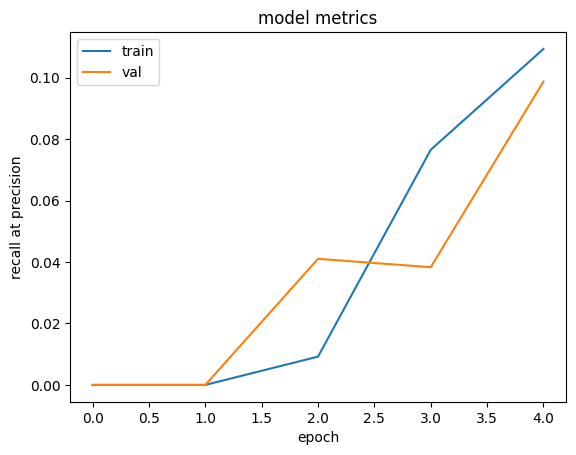

In [18]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 480ms/step


In [20]:
y_valid_report = y_valid.argmax(1)

In [21]:
print(classification_report(y_valid_report.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

       Библиотека       0.00      0.00      0.00         0
   Интернет и СМИ       0.00      0.00      0.00       132
         Из жизни       0.00      0.00      0.00        84
          Легпром       0.00      0.00      0.00         0
         Культура       0.32      0.29      0.30       159
           Бизнес       0.00      0.00      0.00        22
        Экономика       0.46      0.61      0.53       239
      Путешествия       0.00      0.00      0.00        21
    Культпросвет        0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00        23
             Крым       0.00      0.00      0.00         2
  Наука и техника       0.27      0.50      0.35       160
   69-я параллель       0.00      0.00      0.00         4
              Дом       0.00      0.00      0.00        66
Силовые структуры       0.00      0.00      0.00        60
              Мир       0.45      0.57      0.51       

In [16]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

layer1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
layer2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(layer1)
layer3 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(layer2)

dropout = keras.layers.Dropout(rate = 0.4)(layer3)

pool1 = keras.layers.GlobalMaxPooling1D()(dropout)
pool2 = keras.layers.GlobalAveragePooling1D()(dropout)

concat = keras.layers.concatenate((layer3[:, -1, :], pool1, pool2,))

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concat)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 30)   │    722,790 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 256)  │    162,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 200, 256)  │    394,240 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 200, 256)  │    394,240 │ bidirectional_1[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 256)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 256)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ dropout[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ dropout[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 19)        │     14,611 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,688,697 (6.44 MB)

 Trainable params: 1,688,697 (6.44 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5,
         callbacks = [checkpoint, early_stop])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 2.6556 - rec@prec: 0.0000e+00 
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 243s 11s/step - loss: 2.6470 - rec@prec: 0.0000e+00 - val_loss: 2.1269 - val_rec@prec: 0.0000e+00
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 2.0119 - rec@prec: 0.0016  
Epoch 2: val_rec@prec improved from 0.00000 to 0.10775, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 314s 14s/step - loss: 2.0084 - rec@prec: 0.0016 - val_loss: 1.8371 - val_rec@prec: 0.1078
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - loss: 1.7527 - rec@prec: 0.0851 
Epoch 3: val_rec@prec improved from 0.10775 to 0.11903, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 424s 19s/step - loss: 1.7502 - rec@prec: 0.0858 - val_loss: 1.7193 - val_rec@prec: 0.1190
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 1.5145 - rec@prec: 0.1570 
Epoch 4: val_rec@prec did not improv

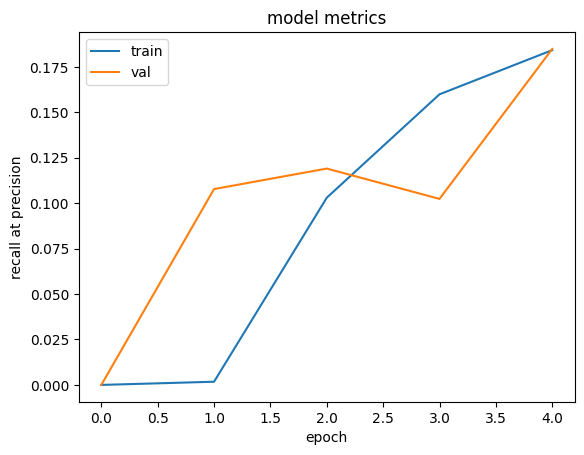

In [19]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
pred = model.predict(X_valid).argmax(1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 61s 868ms/step


In [33]:
y_valid_report = y_valid.argmax(1)

In [34]:
print(classification_report(y_valid_report.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.20      0.04      0.06       159
              Мир       0.44      0.55      0.49       410
           Россия       0.51      0.54      0.53       481
          Легпром       0.00      0.00      0.00         0
      Путешествия       0.00      0.00      0.00        21
             Крым       0.00      0.00      0.00         2
            Спорт       0.90      0.91      0.91       195
Силовые структуры       0.00      0.00      0.00        60
    Культпросвет        0.00      0.00      0.00         1
        Экономика       0.61      0.76      0.68       239
       Библиотека       0.00      0.00      0.00         0
         Ценности       0.00      0.00      0.00        23
           Бизнес       0.00      0.00      0.00        22
   69-я параллель       0.00      0.00      0.00         4
   Интернет и СМИ       0.00      0.00      0.00       132
         Культура       0.30      0.77      0.43       

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите и сравните 3 модели:  
1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM 
2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам. Для того, чтобы сделать residual connection вам нужно будет использовать одинаковую размерность эмбедингов и количество unit'ов в RNN слоях, чтобы их можно было просуммировать 
3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя). В cnn слоях будьте аккуратны с укорачиванием последовательности и используйте паддинг



Сравните качество по метрикам (точность/полнота/f-мера). Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [32]:
import tensorflow as tf

In [24]:
from datasets import load_dataset
dataset = load_dataset("wikiann", 'ru')

README.md:   0%|          | 0.00/158k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/809k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/816k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [25]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [26]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [27]:
id2word = {i:word for word, i in word2id.items()}

In [28]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [34]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [35]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [36]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [37]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [55]:
#1) модель в которой как минимум два рекуррентных слоя, причем один из них GRU, а другой LSTM 
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [56]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 348ms/step - accuracy: 0.8556 - loss: 0.5859 - val_accuracy: 0.9420 - val_loss: 0.1937
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 58s 371ms/step - accuracy: 0.9455 - loss: 0.1694 - val_accuracy: 0.9669 - val_loss: 0.1005
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 236ms/step - accuracy: 0.9754 - loss: 0.0728 - val_accuracy: 0.9736 - val_loss: 0.0775
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.9875 - loss: 0.0389 - val_accuracy: 0.9717 - val_loss: 0.0789
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.9942 - loss: 0.0215 - val_accuracy: 0.9719 - val_loss: 0.0847


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


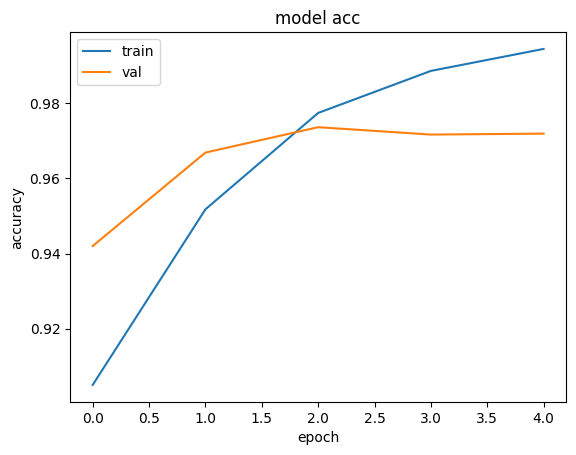

In [57]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step
              precision    recall  f1-score   support

           O       0.91      0.90      0.90     40480
       B-PER       0.67      0.30      0.42      3542
       I-PER       0.92      0.69      0.79      7544
       B-ORG       0.55      0.58      0.56      4074
       I-ORG       0.53      0.81      0.64      8008
       B-LOC       0.53      0.65      0.58      4560
       I-LOC       0.78      0.57      0.66      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.97    540000
   macro avg       0.74      0.69      0.69    540000
weighted avg       0.97      0.97      0.97    540000



In [53]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Alex\AppData\Local\Temp\ipykernel_2272\3091796508.py:5: SyntaxWarning: invalid escape sequence '\w'
  tokens = re.findall('\w+|[^\w\s]+', text)


In [59]:
label_seq(' И молвил отважный Фольтест: «О, благородный Радовид...»', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[('И', 'O'),
 ('молвил', 'B-LOC'),
 ('отважный', 'I-ORG'),
 ('Фольтест', 'I-ORG'),
 (':', 'I-ORG'),
 ('«', 'I-ORG'),
 ('О', 'I-ORG'),
 (',', 'O'),
 ('благородный', 'I-ORG'),
 ('Радовид', 'I-ORG'),
 ('...»', 'I-ORG')]

In [60]:
#2) модель в которой как минимум 3 рекуррентных слоя идут друг за другом и при этом 2-ой и 3-й слои еще имеют residual connection к изначальным эмбедингам.
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=128)(inputs)

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
concat_1 = tf.keras.layers.concatenate((lstm_2, embeddings))
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=True)(concat_1)
concat_2 = tf.keras.layers.concatenate((lstm_3, embeddings))

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(concat_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [61]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 360ms/step - accuracy: 0.8690 - loss: 0.5247 - val_accuracy: 0.9515 - val_loss: 0.1578
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 359ms/step - accuracy: 0.9586 - loss: 0.1295 - val_accuracy: 0.9724 - val_loss: 0.0872
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 358ms/step - accuracy: 0.9815 - loss: 0.0593 - val_accuracy: 0.9763 - val_loss: 0.0724
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - accuracy: 0.9913 - loss: 0.0325 - val_accuracy: 0.9760 - val_loss: 0.0729
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 353ms/step - accuracy: 0.9959 - loss: 0.0181 - val_accuracy: 0.9774 - val_loss: 0.0724


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


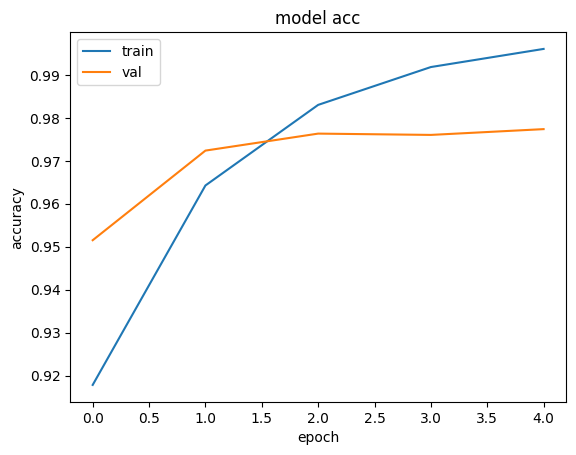

In [62]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step
              precision    recall  f1-score   support

           O       0.93      0.92      0.92     40480
       B-PER       0.68      0.44      0.53      3542
       I-PER       0.88      0.90      0.89      7544
       B-ORG       0.72      0.54      0.62      4074
       I-ORG       0.57      0.79      0.66      8008
       B-LOC       0.65      0.64      0.65      4560
       I-LOC       0.81      0.69      0.74      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.78      0.74      0.75    540000
weighted avg       0.98      0.98      0.98    540000



In [64]:
label_seq('Раньше Сашу тоже вела дорога приключений, но потом ей прострелили колено', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


[('Раньше', 'I-ORG'),
 ('Сашу', 'I-ORG'),
 ('тоже', 'O'),
 ('вела', 'I-ORG'),
 ('дорога', 'I-ORG'),
 ('приключений', 'I-ORG'),
 (',', 'O'),
 ('но', 'O'),
 ('потом', 'O'),
 ('ей', 'O'),
 ('прострелили', 'O'),
 ('колено', 'O')]

In [ ]:
#3) модель в которой будут и рекуррентные и сверточные слои (как минимум 2 rnn и как минимум 2 cnn слоя).
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
conv_1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(lstm_1)

lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(conv_1)
conv_2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(conv_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])

In [50]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.9050 - loss: 0.2676 - val_accuracy: 0.9480 - val_loss: 0.1526
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.9580 - loss: 0.1250 - val_accuracy: 0.9697 - val_loss: 0.0922
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.9799 - loss: 0.0594 - val_accuracy: 0.9775 - val_loss: 0.0728
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 283ms/step - accuracy: 0.9915 - loss: 0.0268 - val_accuracy: 0.9787 - val_loss: 0.0813
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 282ms/step - accuracy: 0.9968 - loss: 0.0117 - val_accuracy: 0.9777 - val_loss: 0.0931


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


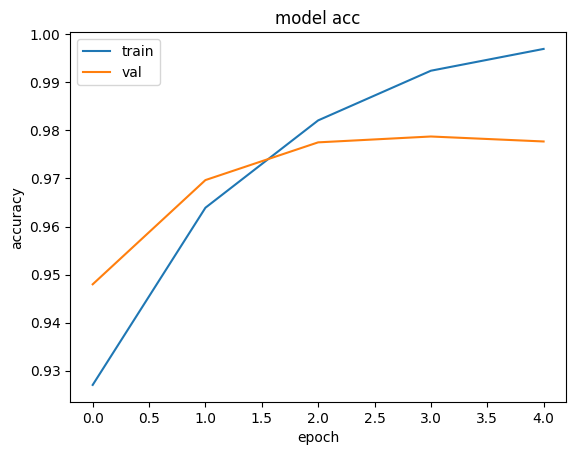

In [51]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
pred = model.predict(X_test).argmax(2)
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
              precision    recall  f1-score   support

           O       0.96      0.88      0.92     40480
       B-PER       0.93      0.73      0.82      3542
       I-PER       0.95      0.74      0.83      7544
       B-ORG       0.55      0.66      0.60      4074
       I-ORG       0.62      0.82      0.70      8008
       B-LOC       0.56      0.83      0.67      4560
       I-LOC       0.73      0.76      0.75      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.79      0.80      0.79    540000
weighted avg       0.98      0.98      0.98    540000



In [54]:
label_seq('Ходят слухи, что орки из Мории заключили союз с Некромантом из Дол-Гулдура.', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


[('Ходят', 'O'),
 ('слухи', 'B-LOC'),
 (',', 'O'),
 ('что', 'O'),
 ('орки', 'O'),
 ('из', 'O'),
 ('Мории', 'B-ORG'),
 ('заключили', 'I-ORG'),
 ('союз', 'I-ORG'),
 ('с', 'O'),
 ('Некромантом', 'B-ORG'),
 ('из', 'O'),
 ('Дол', 'O'),
 ('-', 'O'),
 ('Гулдура', 'B-LOC'),
 ('.', 'O')]